# Logistic Regression for Fraud Detection
## Implementation & Evaluation

This notebook implements logistic regression for fraud detection using our dataset and demonstrates proper evaluation techniques for classification models in the fraud detection context.

## Table of Contents
1. [Data Loading and Exploration](#1-data-loading-and-exploration)
2. [Feature Engineering and Preprocessing](#2-feature-engineering-and-preprocessing)
3. [Logistic Regression Implementation](#3-logistic-regression-implementation)
4. [Model Evaluation for Fraud Detection](#4-model-evaluation-for-fraud-detection)
5. [Threshold Optimization](#5-threshold-optimization)
6. [Probability Calibration](#6-probability-calibration)
7. [Feature Importance Analysis](#7-feature-importance-analysis)
8. [Conclusion and Next Steps](#8-conclusion-and-next-steps)

## 1. Data Loading and Exploration

Let's begin by loading the fraud dataset and examining its structure. In a fraud detection context, understanding the data distribution is particularly important due to class imbalance.

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-whitegrid')
sns.set_palette("deep")
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'xtick.labelsize': 12, 
                     'ytick.labelsize': 12, 'legend.fontsize': 12})

# Load the fraud dataset
# Note: In a real scenario, you'd load the full dataset. Here we're using the sample provided.
df = pd.read_csv('fraud_train.csv')
df = df.drop('Unnamed: 0', axis=1)

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (100000, 31)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,0,0.5,0.533645,-1,47,20,0.010426,-0.775947,AC,1688,...,-1,0,1500.0,0,INTERNET,30.650408,other,0,1,3
1,0,0.6,0.762213,198,8,20,0.020051,10.628024,AA,1549,...,28,0,500.0,0,INTERNET,2.045171,other,1,1,5
2,0,0.9,0.386071,60,12,20,7.009744,51.695466,AA,1520,...,29,0,1000.0,0,INTERNET,11.071376,linux,1,1,4
3,0,0.6,0.311304,-1,221,40,0.012369,-1.236389,AB,991,...,11,0,1500.0,0,INTERNET,10.796589,linux,1,1,6
4,0,0.1,0.824045,86,6,20,0.039485,-0.659062,AC,1538,...,-1,0,200.0,0,INTERNET,6.790446,linux,1,1,3


First, let's explore the target variable distribution to confirm the expected class imbalance typical in fraud detection.

Fraudulent transactions: 1059 (1.06%)
Legitimate transactions: 98941 (98.94%)


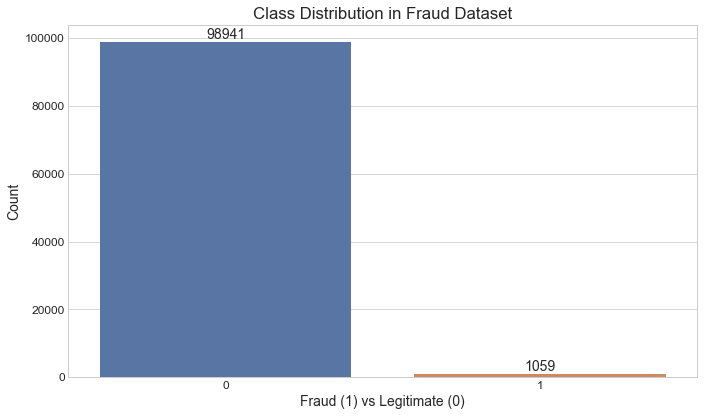

In [8]:
# Check class distribution
fraud_count = df['fraud_bool'].sum()
non_fraud_count = len(df) - fraud_count
fraud_percentage = fraud_count / len(df) * 100

print(f"Fraudulent transactions: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Legitimate transactions: {non_fraud_count} ({100-fraud_percentage:.2f}%)")

# Visualize class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='fraud_bool', data=df)
plt.title('Class Distribution in Fraud Dataset')
plt.xlabel('Fraud (1) vs Legitimate (0)')
plt.ylabel('Count')

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

Now let's examine the relationship between our features and the fraud target. We'll focus on the features highlighted in our slides as potentially strong predictors.

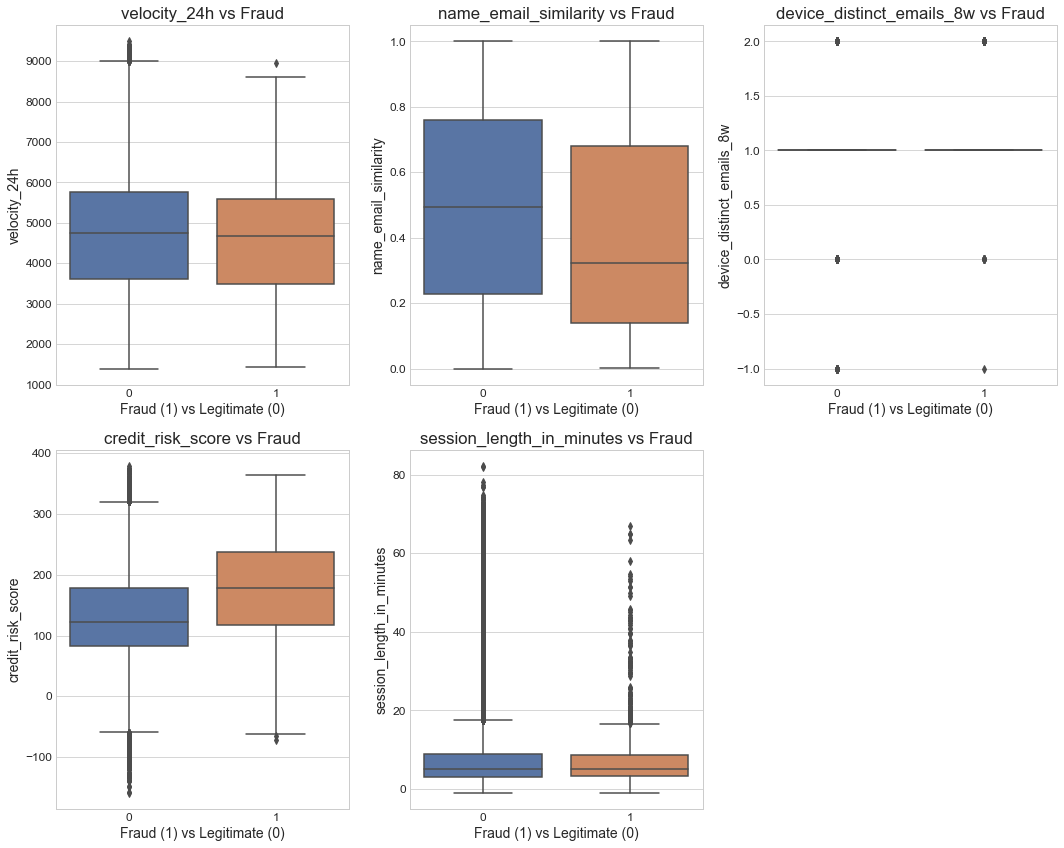

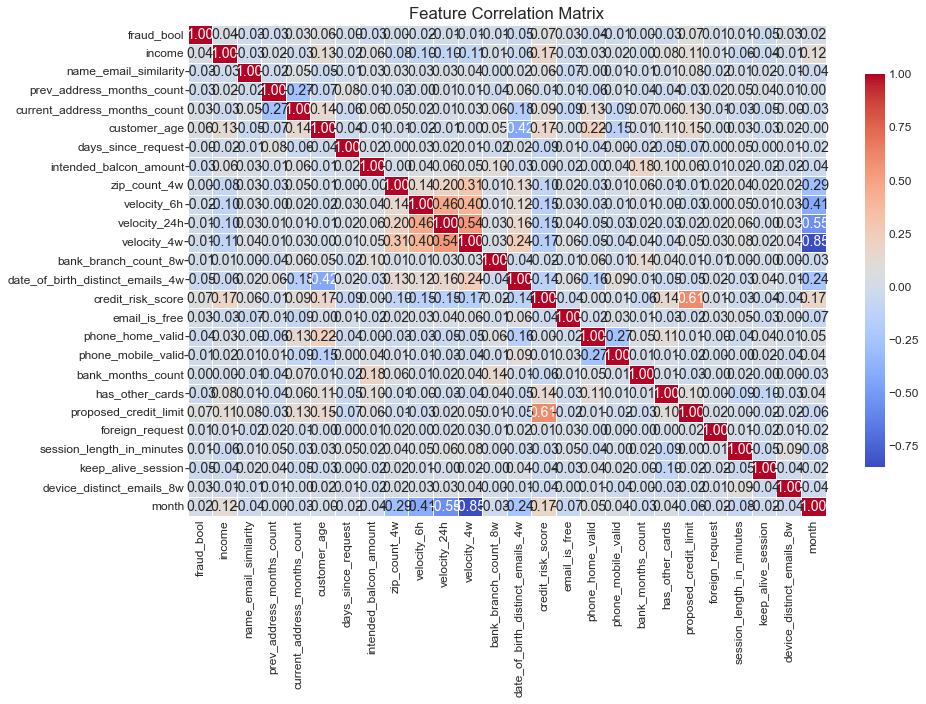

Top 10 features correlated with fraud:
fraud_bool                      1.000000
credit_risk_score               0.070968
proposed_credit_limit           0.068893
customer_age                    0.061804
income                          0.037713
current_address_months_count    0.033111
email_is_free                   0.032436
device_distinct_emails_8w       0.026774
month                           0.015241
foreign_request                 0.010074
session_length_in_minutes       0.007253
Name: fraud_bool, dtype: float64


In [9]:
# Select key features based on prior knowledge
key_features = ['velocity_24h', 'name_email_similarity', 'device_distinct_emails_8w', 
                'credit_risk_score', 'session_length_in_minutes']

# Create pairplot to visualize relationships
plt.figure(figsize=(15, 12))
for i, feature in enumerate(key_features):
    if feature in df.columns:
        plt.subplot(2, 3, i+1)
        sns.boxplot(x='fraud_bool', y=feature, data=df)
        plt.title(f'{feature} vs Fraud')
        plt.xlabel('Fraud (1) vs Legitimate (0)')
        plt.tight_layout()

plt.show()

# Correlation analysis
correlation_matrix = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, 
            fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Focusing on correlation with target
correlation_with_fraud = correlation_matrix['fraud_bool'].sort_values(ascending=False)
print("Top 10 features correlated with fraud:")
print(correlation_with_fraud.head(11))  # Including fraud_bool itself

## 2. Feature Engineering and Preprocessing

In fraud detection, effective feature engineering can significantly improve model performance. We'll preprocess our data while paying special attention to aspects particularly relevant to fraud detection.

### 2.1 Handling Missing Values

Missing values in fraud detection can themselves be signals - fraudsters often leave fields blank or provide inconsistent information.

In [10]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 
                           'Percentage': missing_percent})
print("Missing values summary:")
print(missing_df[missing_df['Missing Values'] > 0])

# Strategy for missing values
# We'll create a flag for missingness but also impute for model compatibility
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('fraud_bool')  # Remove target variable

# Create missing flags where needed (if we had missing values)
for feature in numeric_features:
    if df[feature].isnull().sum() > 0:
        df[f'{feature}_missing'] = df[feature].isnull().astype(int)

# Impute missing values
for feature in numeric_features:
    if df[feature].isnull().sum() > 0:
        # In fraud detection, using median is often better than mean due to outliers
        df[feature].fillna(df[feature].median(), inplace=True)

Missing values summary:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


### 2.2 Feature Encoding and Scaling

Proper encoding of categorical variables and scaling of numerical features is essential for logistic regression.

In [11]:
# Identify categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical features: {categorical_features}")

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
print(f"Shape after one-hot encoding: {df_encoded.shape}")

# Prepare features and target
X = df_encoded.drop('fraud_bool', axis=1)
y = df_encoded['fraud_bool']

# Split data into training and testing sets
# In fraud detection, stratification is crucial due to class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Scale features - important for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames with feature names preserved
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Categorical features: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
Shape after one-hot encoding: (100000, 47)
Training set shape: (75000, 46)
Testing set shape: (25000, 46)


### 2.3 Addressing Class Imbalance

Fraud detection typically involves severe class imbalance which must be addressed to create effective models.

In [13]:
# Check class distribution in the training set
train_fraud_percent = y_train.mean() * 100
print(f"Fraud percentage in training set: {train_fraud_percent:.2f}%")

# In a real scenario with extreme imbalance (e.g., 0.1% fraud),
# we would implement one of these strategies:

# Strategy 1: Class weights (we'll implement this one)
# Automatically adjusts the loss function to penalize misclassifications 
# of the minority class more heavily

# Strategy 2: Sampling methods
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Commented out as we'll use class weights instead
# """
# # SMOTE: Synthetic Minority Over-sampling Technique
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# # Undersampling
# undersampler = RandomUnderSampler(random_state=42)
# X_train_under, y_train_under = undersampler.fit_resample(X_train_scaled, y_train)

# # Combined approach
# smote_enn = SMOTEENN(random_state=42)
# X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train_scaled, y_train)

# print(f"Original class distribution: {pd.Series(y_train).value_counts(normalize=True)}")
# print(f"After SMOTE: {pd.Series(y_train_smote).value_counts(normalize=True)}")
# print(f"After undersampling: {pd.Series(y_train_under).value_counts(normalize=True)}")
# print(f"After SMOTEENN: {pd.Series(y_train_smoteenn).value_counts(normalize=True)}")
# """

Fraud percentage in training set: 1.06%


## 3. Logistic Regression Implementation

Now we'll implement the logistic regression model, with specific considerations for fraud detection.

In [14]:
# Calculate class weights inversely proportional to class frequencies
# For severe imbalance, this helps the model pay more attention to the minority class
fraud_ratio = y_train.mean()
class_weights = {0: fraud_ratio, 1: 1-fraud_ratio}
print(f"Class weights: {class_weights}")

# Train logistic regression model with class weights
# We'll use L2 regularization (ridge) to prevent overfitting
logistic_model = LogisticRegression(
    penalty='l2',  # L2 regularization
    C=1.0,         # Inverse of regularization strength
    solver='liblinear',  # Efficient for small datasets
    class_weight=class_weights,  # Address class imbalance
    random_state=42,
    max_iter=1000
)

# Fit the model
logistic_model.fit(X_train_scaled, y_train)

# Make predictions (both class labels and probabilities)
y_pred = logistic_model.predict(X_test_scaled)
y_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probability of fraud

print("Logistic Regression model fitted successfully.")

Class weights: {0: 0.010586666666666666, 1: 0.9894133333333334}
Logistic Regression model fitted successfully.


Let's look at the model coefficients to understand which features are most influential in detecting fraud:

Top 10 most important features for fraud detection:
                      Feature  Coefficient  Abs_Coefficient
44          device_os_windows     0.595128         0.595128
18            has_other_cards    -0.543138         0.543138
15           phone_home_valid    -0.517981         0.517981
35          housing_status_BB    -0.486064         0.486064
36          housing_status_BC    -0.476071         0.476071
38          housing_status_BE    -0.457904         0.457904
14              email_is_free     0.366920         0.366920
2   prev_address_months_count    -0.364224         0.364224
26            payment_type_AC     0.352172         0.352172
22         keep_alive_session    -0.320021         0.320021


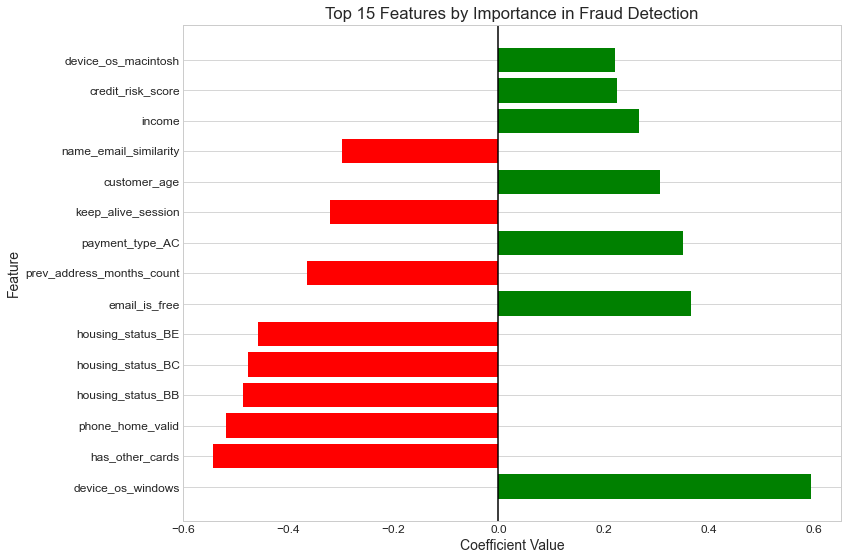

In [15]:
# Examine model coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logistic_model.coef_[0]
})

# Sort by absolute coefficient value
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients_sorted = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("Top 10 most important features for fraud detection:")
print(coefficients_sorted.head(10))

# Visualize top coefficients
plt.figure(figsize=(12, 8))
top_coef = coefficients_sorted.head(15)
colors = ['red' if x < 0 else 'green' for x in top_coef['Coefficient']]
plt.barh(top_coef['Feature'], top_coef['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 15 Features by Importance in Fraud Detection')
plt.axvline(x=0, color='black', linestyle='-')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

## 4. Model Evaluation for Fraud Detection

Proper evaluation of fraud detection models requires metrics beyond accuracy, as accuracy can be misleading with imbalanced data.

### 4.1 Classification Metrics

Accuracy: 0.8081
Precision: 0.0420
Recall: 0.7849
F1 Score: 0.0798


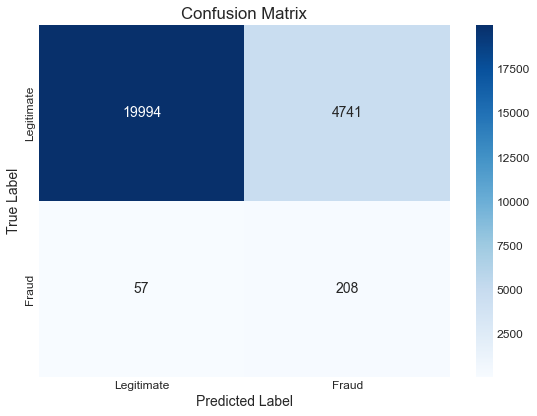

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     24735
           1       0.04      0.78      0.08       265

    accuracy                           0.81     25000
   macro avg       0.52      0.80      0.49     25000
weighted avg       0.99      0.81      0.88     25000



In [16]:
# Basic classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report (provides precision, recall, f1 for each class)
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

### 4.2 Beyond Basic Metrics: ROC and Precision-Recall Curves

ROC curves are common in classification tasks, but in fraud detection with severe imbalance, Precision-Recall curves are often more informative.

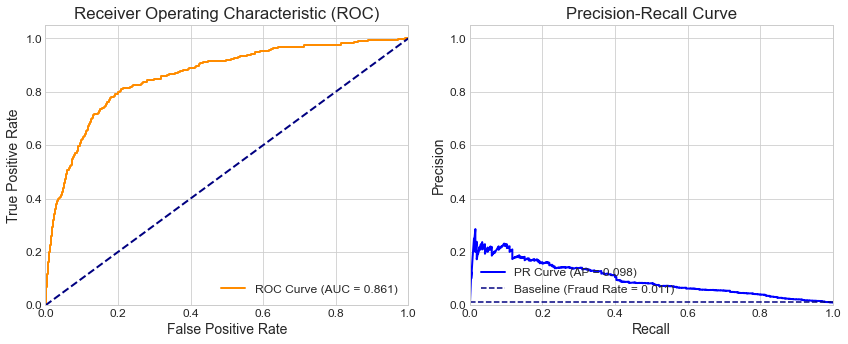


Why Precision-Recall curves are often better for fraud detection:
1. They focus on the positive (fraud) class performance
2. They don't consider true negatives, which dominate in imbalanced scenarios
3. They provide better visibility into model performance at different thresholds
4. The baseline (random) performance is the fraud rate, not 0.5 as in ROC


In [17]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate Precision-Recall curve and average precision
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='blue', lw=2, 
         label=f'PR Curve (AP = {avg_precision:.3f})')
plt.axhline(y=y_test.mean(), color='navy', linestyle='--', 
            label=f'Baseline (Fraud Rate = {y_test.mean():.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Why Precision-Recall is better for fraud:
print("\nWhy Precision-Recall curves are often better for fraud detection:")
print("1. They focus on the positive (fraud) class performance")
print("2. They don't consider true negatives, which dominate in imbalanced scenarios")
print("3. They provide better visibility into model performance at different thresholds")
print("4. The baseline (random) performance is the fraud rate, not 0.5 as in ROC")

## 5. Threshold Optimization

In fraud detection, the default 0.5 threshold is rarely optimal. We need to find a threshold that balances business objectives.

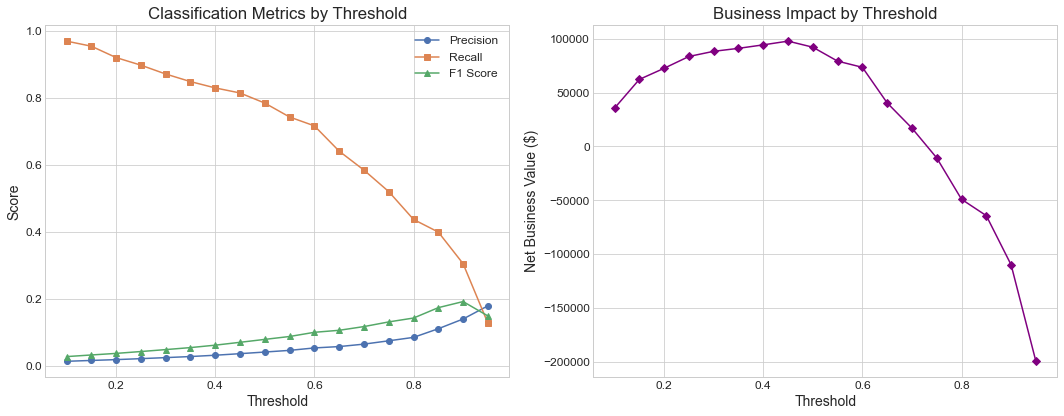

Optimal Threshold: 0.45
At this threshold:
  Precision: 0.0371
  Recall: 0.8151
  F1 Score: 0.0711
  Net Business Value: $97652.00


In [18]:
# Create a dataframe with different thresholds and their corresponding metrics
thresholds = np.arange(0.1, 1.0, 0.05)
threshold_metrics = []

for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    precision_custom = precision_score(y_test, y_pred_custom)
    recall_custom = recall_score(y_test, y_pred_custom)
    f1_custom = f1_score(y_test, y_pred_custom)
    
    # Business metrics (simplified)
    # Assume: 
    # - Each fraudulent transaction costs $1000 on average
    # - Each manual review costs $10
    # - Each false positive causes $2 in customer friction
    
    true_positives = ((y_pred_custom == 1) & (y_test == 1)).sum()
    false_positives = ((y_pred_custom == 1) & (y_test == 0)).sum()
    false_negatives = ((y_pred_custom == 0) & (y_test == 1)).sum()
    
    fraud_savings = true_positives * 1000
    review_cost = (true_positives + false_positives) * 10
    friction_cost = false_positives * 2
    missed_fraud_cost = false_negatives * 1000
    
    net_value = fraud_savings - review_cost - friction_cost - missed_fraud_cost
    
    threshold_metrics.append({
        'Threshold': threshold,
        'Precision': precision_custom,
        'Recall': recall_custom,
        'F1': f1_custom,
        'TP': true_positives,
        'FP': false_positives,
        'FN': false_negatives,
        'Net Value': net_value
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Plot metrics across thresholds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(threshold_df['Threshold'], threshold_df['Precision'], marker='o', label='Precision')
plt.plot(threshold_df['Threshold'], threshold_df['Recall'], marker='s', label='Recall')
plt.plot(threshold_df['Threshold'], threshold_df['F1'], marker='^', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Classification Metrics by Threshold')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(threshold_df['Threshold'], threshold_df['Net Value'], marker='D', color='purple')
plt.xlabel('Threshold')
plt.ylabel('Net Business Value ($)')
plt.title('Business Impact by Threshold')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find optimal threshold based on business value
optimal_threshold_idx = threshold_df['Net Value'].idxmax()
optimal_threshold = threshold_df.loc[optimal_threshold_idx, 'Threshold']
optimal_metrics = threshold_df.loc[optimal_threshold_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"At this threshold:")
print(f"  Precision: {optimal_metrics['Precision']:.4f}")
print(f"  Recall: {optimal_metrics['Recall']:.4f}")
print(f"  F1 Score: {optimal_metrics['F1']:.4f}")
print(f"  Net Business Value: ${optimal_metrics['Net Value']:.2f}")

## 6. Probability Calibration

For risk scoring in fraud detection, well-calibrated probabilities are essential. Let's check how well our model is calibrated.

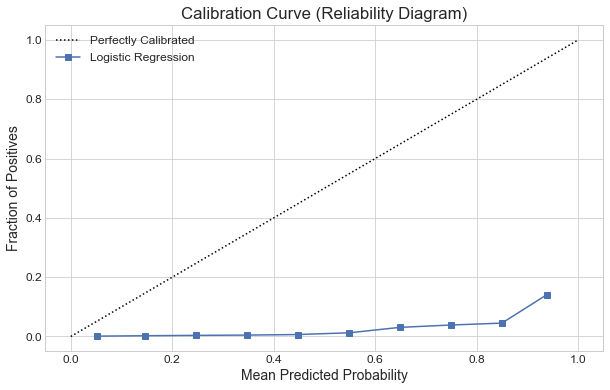

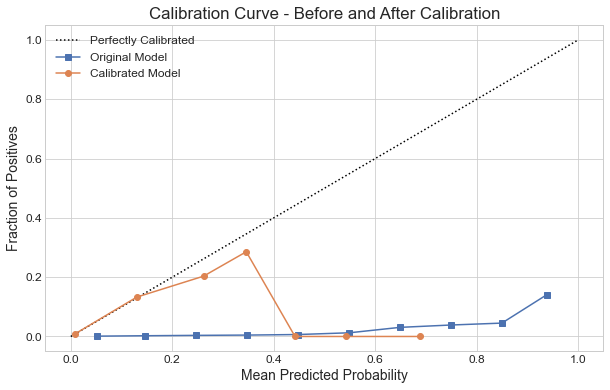

Why calibration matters in fraud detection:
1. Risk scores must reflect actual fraud likelihood
2. Business decisions rely on accurate probability estimates
3. Resource allocation (manual review, investigation) depends on risk level
4. Customer experience degrades if risk scores are inflated


In [19]:
# Check probability calibration
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Logistic Regression')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.grid(True)
plt.show()

# If calibration is poor, we could use a calibrated model:
calibrated_model = CalibratedClassifierCV(logistic_model, method='isotonic', cv=5)
calibrated_model.fit(X_train_scaled, y_train)
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test_scaled)[:, 1]

# Check calibration after adjustment
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_pred_proba_calibrated, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Original Model')
plt.plot(prob_pred_cal, prob_true_cal, 'o-', label='Calibrated Model')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - Before and After Calibration')
plt.legend()
plt.grid(True)
plt.show()

print("Why calibration matters in fraud detection:")
print("1. Risk scores must reflect actual fraud likelihood")
print("2. Business decisions rely on accurate probability estimates")
print("3. Resource allocation (manual review, investigation) depends on risk level")
print("4. Customer experience degrades if risk scores are inflated")

## 7. Feature Importance Analysis

Understanding which features drive fraud predictions is crucial for both model improvement and business insights.

Top 10 features by importance:
                      Feature  Coefficient  Odds_Multiplier     Impact
44          device_os_windows     0.595128         1.813263  81.326272
18            has_other_cards    -0.543138         0.580922  41.907756
15           phone_home_valid    -0.517981         0.595722  40.427792
35          housing_status_BB    -0.486064         0.615042  38.495771
36          housing_status_BC    -0.476071         0.621220  37.878040
38          housing_status_BE    -0.457904         0.632608  36.739171
14              email_is_free     0.366920         1.443283  44.328312
2   prev_address_months_count    -0.364224         0.694736  30.526445
26            payment_type_AC     0.352172         1.422154  42.215379
22         keep_alive_session    -0.320021         0.726134  27.386602


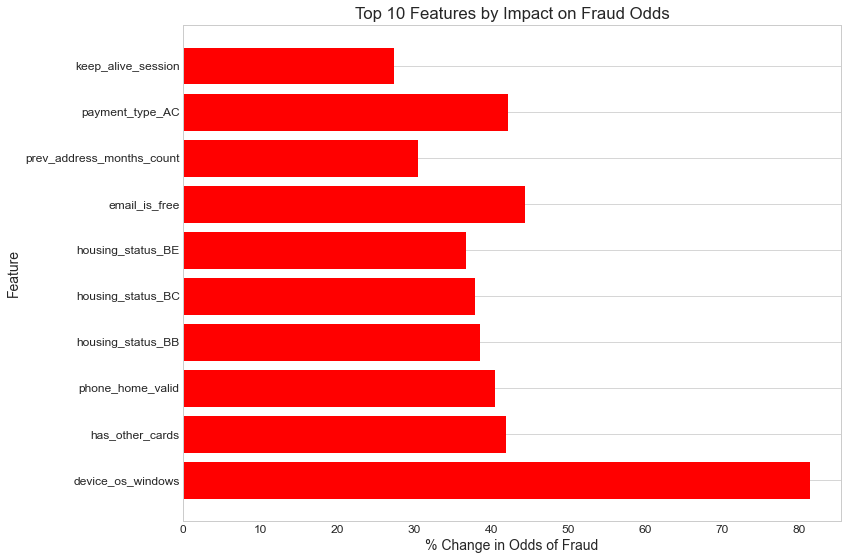


Feature Importance Interpretation:
1. Positive coefficients increase fraud probability
2. Negative coefficients decrease fraud probability
3. The odds multiplier shows how much a one-unit increase in the feature multiplies the odds of fraud
4. The impact percentage shows the relative effect on fraud odds


In [20]:
# More detailed feature importance analysis
# Get feature coefficients in original scale
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logistic_model.coef_[0],
    'Abs_Coefficient': np.abs(logistic_model.coef_[0])
})

# Sort by absolute importance
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Calculate impact on odds
feature_importance['Odds_Multiplier'] = np.exp(feature_importance['Coefficient'])
feature_importance['Impact'] = np.where(
    feature_importance['Coefficient'] > 0, 
    (feature_importance['Odds_Multiplier'] - 1) * 100,
    (1 - feature_importance['Odds_Multiplier']) * 100
)

# Display top features
print("Top 10 features by importance:")
top_features = feature_importance.head(10)
print(top_features[['Feature', 'Coefficient', 'Odds_Multiplier', 'Impact']])

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Impact'], 
         color=np.where(top_features['Impact'] > 0, 'red', 'green'))
plt.xlabel('% Change in Odds of Fraud')
plt.ylabel('Feature')
plt.title('Top 10 Features by Impact on Fraud Odds')
plt.axvline(x=0, color='black', linestyle='-')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Feature importance interpretation
print("\nFeature Importance Interpretation:")
print("1. Positive coefficients increase fraud probability")
print("2. Negative coefficients decrease fraud probability")
print("3. The odds multiplier shows how much a one-unit increase in the feature multiplies the odds of fraud")
print("4. The impact percentage shows the relative effect on fraud odds")

## 8. Conclusion and Next Steps

In [21]:
# Summarize key findings and performance
print("Model Performance Summary:")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"F1 Score at Optimal Threshold: {optimal_metrics['F1']:.4f}")

print("\nKey Fraud Indicators:")
for i in range(min(5, len(top_features))):
    feature = top_features.iloc[i]
    direction = "increases" if feature['Coefficient'] > 0 else "decreases"
    print(f"- {feature['Feature']} {direction} fraud odds by {abs(feature['Impact']):.1f}%")

print("\nStrengths of Logistic Regression for Fraud Detection:")
print("1. Interpretable coefficients provide business insights")
print("2. Fast training and prediction suitable for real-time scoring")
print("3. Provides well-calibrated probability estimates")
print("4. Serves as a strong baseline for more complex models")

print("\nLimitations of This Approach:")
print("1. Linear decision boundary may miss complex fraud patterns")
print("2. Limited ability to capture feature interactions")
print("3. Requires manual feature engineering")
print("4. May underperform with highly imbalanced data")

print("\nNext Steps:")
print("1. Experiment with feature interactions and polynomial features")
print("2. Try ensemble methods (Random Forest, XGBoost) for comparison")
print("3. Move to neural network architectures (perceptron, MLP)")
print("4. Incorporate temporal patterns and sequence modeling")
print("5. Deploy model in a monitoring framework to detect concept drift")

Model Performance Summary:
AUC-ROC: 0.8606
Average Precision: 0.0985
Optimal Threshold: 0.45
F1 Score at Optimal Threshold: 0.0711

Key Fraud Indicators:
- device_os_windows increases fraud odds by 81.3%
- has_other_cards decreases fraud odds by 41.9%
- phone_home_valid decreases fraud odds by 40.4%
- housing_status_BB decreases fraud odds by 38.5%
- housing_status_BC decreases fraud odds by 37.9%

Strengths of Logistic Regression for Fraud Detection:
1. Interpretable coefficients provide business insights
2. Fast training and prediction suitable for real-time scoring
3. Provides well-calibrated probability estimates
4. Serves as a strong baseline for more complex models

Limitations of This Approach:
1. Linear decision boundary may miss complex fraud patterns
2. Limited ability to capture feature interactions
3. Requires manual feature engineering
4. May underperform with highly imbalanced data

Next Steps:
1. Experiment with feature interactions and polynomial features
2. Try ensembl

This notebook demonstrated implementing and evaluating a logistic regression model for fraud detection. We covered feature engineering, handling class imbalance, threshold optimization, probability calibration, and interpretation of results. The model serves as a strong baseline for comparison with more complex approaches, which we'll explore in subsequent parts of this lecture series.

## Additional Considerations for Fraud Detection

- **Concept Drift**: Fraud patterns evolve rapidly, requiring regular model updates
- **Feature Stability**: Monitor feature distributions for unexpected changes
- **Operational Integration**: Consider latency requirements for real-time scoring
- **Regulatory Compliance**: Ensure model explanations satisfy regulatory requirements
- **Cost-Sensitive Evaluation**: Continue to refine business impact metrics

In the next section, we'll transition to neural network architectures, starting with the perceptron and progressing to multilayer perceptrons (MLPs) with Keras.